<a href="https://colab.research.google.com/github/Junha9/AI/blob/master/Self_Learning_ML_DL/Chapter_09_2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from keras.datasets import imdb
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [37]:
# Prepare the imdb data
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [38]:
# convert data to torch tensor
print(train_seq.shape, train_target.shape)
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)
print(train_target.dtype)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
print(train_target.dtype)

(20000, 100) (20000,)
int64
torch.float32


In [39]:
# make and load the tensor dataset
train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [40]:
# Let's build a model, inherited from nn.Module
class IMDBRnn(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(500, 16)
    self.rnn = nn.RNN(16, 8, batch_first=True)
    self.dense = nn.Linear(8,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.embedding(x)
    _, hidden = self.rnn(x)
    outputs = self.dense(hidden[-1])
    return self.sigmoid(outputs)

In [41]:
# load the model to device, prepare loss function and optimizer
model = IMDBRnn()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [57]:
# train the model
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
  model.train()
  train_loss = 0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), targets)
      val_loss += loss.item()
  train_loss = train_loss/len(train_loader)
  val_loss = val_loss/len(val_loader)
  train_hist.append(train_loss)
  val_hist.append(val_loss)
  print(f"epoch: {epoch+1},",
        f"train loss:{train_loss:.4f}, val loss:{val_loss:.4f}")
  if best_loss == -1 or val_loss < best_loss:
    best_loss = val_loss
    early_stopping_counter = 0
    torch.save(model.state_dict(), 'best_rnn_model.pt')
  else:
    early_stopping_counter +=1
    if early_stopping_counter >= patience:
      print(f"early stopped at {epoch+1}th epoch")
      break


epoch: 1, train loss:0.6769, val loss:0.6802
epoch: 2, train loss:0.6751, val loss:0.6788
epoch: 3, train loss:0.6734, val loss:0.6775
epoch: 4, train loss:0.6715, val loss:0.6758
epoch: 5, train loss:0.6695, val loss:0.6742
epoch: 6, train loss:0.6677, val loss:0.6729
epoch: 7, train loss:0.6655, val loss:0.6711
epoch: 8, train loss:0.6634, val loss:0.6692
epoch: 9, train loss:0.6610, val loss:0.6671
epoch: 10, train loss:0.6587, val loss:0.6649
epoch: 11, train loss:0.6564, val loss:0.6626
epoch: 12, train loss:0.6537, val loss:0.6599
epoch: 13, train loss:0.6510, val loss:0.6570
epoch: 14, train loss:0.6477, val loss:0.6537
epoch: 15, train loss:0.6438, val loss:0.6499
epoch: 16, train loss:0.6392, val loss:0.6450
epoch: 17, train loss:0.6343, val loss:0.6417
epoch: 18, train loss:0.6290, val loss:0.6367
epoch: 19, train loss:0.6231, val loss:0.6323
epoch: 20, train loss:0.6175, val loss:0.6288
epoch: 21, train loss:0.6124, val loss:0.6239
epoch: 22, train loss:0.6072, val loss:0.61

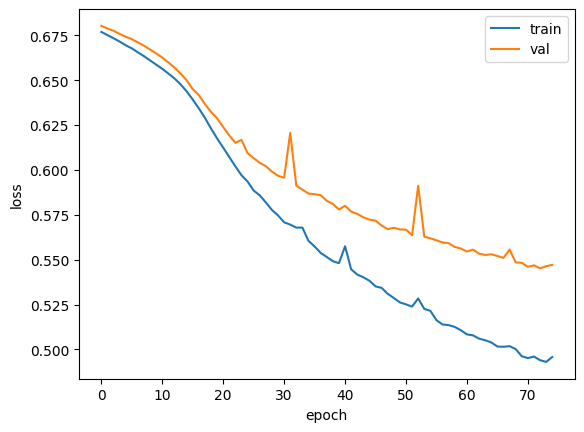

In [61]:
# plot the loss
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [62]:
# check validation accuracy
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predicts = outputs > 0.5
    corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"valdation accuracy: {accuracy:.4f}")

valdation accuracy: 0.7360
